In [29]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import LogNorm
import numpy as np
from scipy.optimize import least_squares
from aa_helpers import create_plot_with_background
import pandas as pd
import glob
import seaborn as sns


In [30]:
df = pd.read_feather("combined_all_lambda_data.feather")
df

,event,lam_id,lam_pdg,lam_gen,lam_sim,lam_px,lam_py,lam_pz,lam_vx,lam_vy,...,gamtwo_py,gamtwo_pz,gamtwo_vx,gamtwo_vy,gamtwo_vz,gamtwo_epx,gamtwo_epy,gamtwo_epz,gamtwo_time,gamtwo_nd
0,0,4,3122,1,134217728,-0.481806,0.667223,22.881677,-0.065840,-0.008148,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,4,3122,1,134217728,-0.139277,0.062614,31.113912,-0.067507,0.000640,...,0.082274,3.843211,-4.236915,1.875058,940.263365,-182.985431,130.331637,6940.804748,3.073184,0.0
2,2,4,3122,1,134217728,-1.666138,0.211775,30.953969,-0.027048,0.006753,...,-0.035283,2.576297,-16.709645,2.127195,331.802817,-236.338462,-40.261238,3426.886648,0.948990,0.0
3,3,4,3122,1,134217728,-0.047907,0.293727,20.976907,0.073658,-0.005835,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,3122,1,134217728,-0.728119,-0.635623,31.608930,-0.042067,0.001390,...,-0.015382,1.622836,-39.878694,-34.774637,1675.921870,-96.233964,-84.811255,6954.767017,5.966232,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563784,499995,4,3122,1,134217728,-0.009053,-0.654791,26.745864,-0.101977,-0.012837,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
563785,499996,4,3122,1,134217728,-0.884341,-0.615085,37.018614,-0.011745,-0.024622,...,0.054056,4.083450,-3.373053,-2.362499,184.886373,-227.016039,87.304909,6958.468336,0.329498,0.0
563786,499997,4,3122,1,134217728,-1.299756,-0.123300,25.804004,0.224168,-0.014203,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
563787,499998,4,3122,1,134217728,-0.165018,-0.626539,24.329761,-0.050402,0.038077,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
p_pi_minus_decays = df[
    df['prot_id'].notna() & 
    df['pimin_id'].notna() &
    df['neut_id'].isna() &    
    df['pizero_id'].isna()    
].copy()



In [32]:
m_proton = 0.93827  
m_pion = 0.13957    


p_pi_minus_decays['prot_E'] = np.sqrt(
    p_pi_minus_decays['prot_px']**2 + 
    p_pi_minus_decays['prot_py']**2 + 
    p_pi_minus_decays['prot_pz']**2 + 
    m_proton**2
)

p_pi_minus_decays['pimin_E'] = np.sqrt(
    p_pi_minus_decays['pimin_px']**2 + 
    p_pi_minus_decays['pimin_py']**2 + 
    p_pi_minus_decays['pimin_pz']**2 + 
    m_pion**2
)


p_pi_minus_decays['lambda_E'] = p_pi_minus_decays['prot_E'] + p_pi_minus_decays['pimin_E']


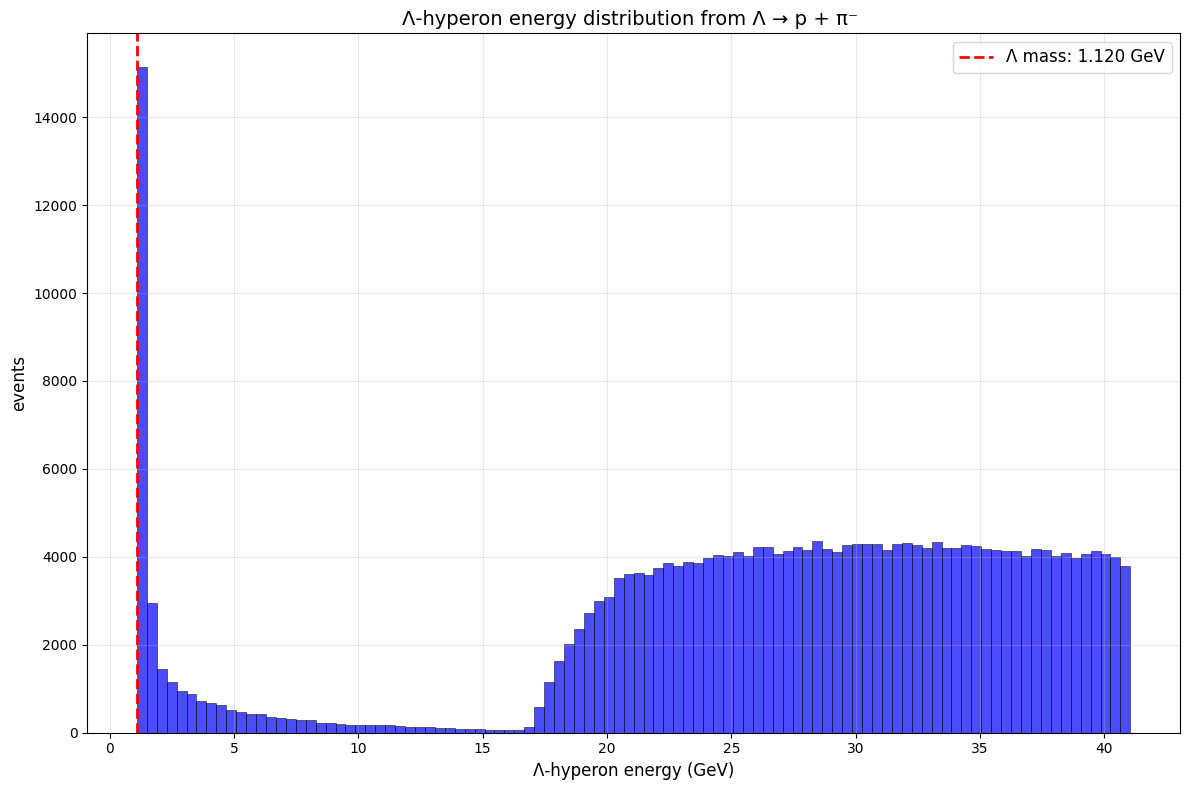

In [37]:
plt.figure(figsize=(12, 8))

plt.hist(p_pi_minus_decays['lambda_E'], bins=100, alpha=0.7, color='blue', 
         edgecolor='black', linewidth=0.5)

plt.axvline(1.120, color='red', linestyle='--', linewidth=2, 
           label='Λ mass: 1.120 GeV')

plt.xlabel('Λ-hyperon energy (GeV)', fontsize=12)
plt.ylabel('events', fontsize=12)
plt.title('Λ-hyperon energy distribution from Λ → p + π⁻ ', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Calculate invariant mass of p + π⁻ system
def calculate_invariant_mass(row):
    E_total = row['prot_E'] + row['pimin_E']
    px_total = row['prot_px'] + row['pimin_px']
    py_total = row['prot_py'] + row['pimin_py']
    pz_total = row['prot_pz'] + row['pimin_pz']
    p_total_sq = px_total**2 + py_total**2 + pz_total**2
    return np.sqrt(E_total**2 - p_total_sq)

p_pi_minus_decays['invariant_mass'] = p_pi_minus_decays.apply(calculate_invariant_mass, axis=1)


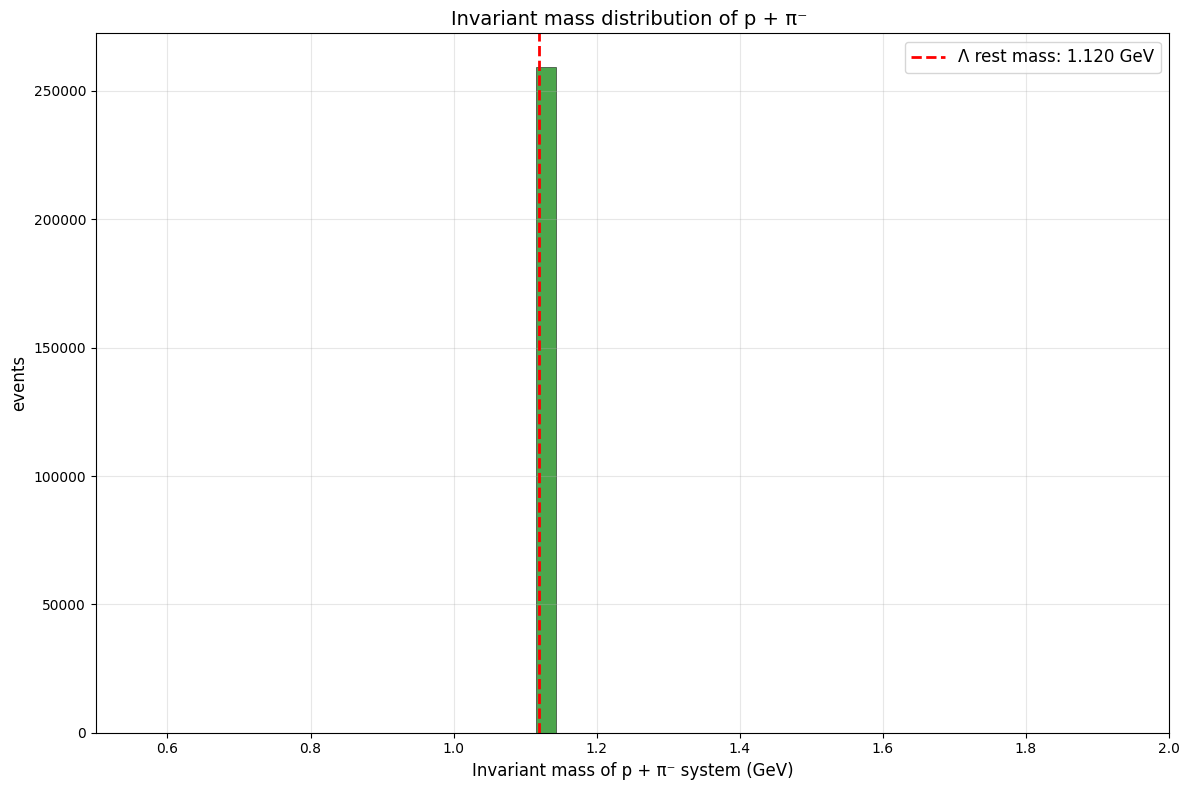

In [ ]:
plt.figure(figsize=(12, 8))

plt.hist(p_pi_minus_decays['invariant_mass'], 
         bins=100, 
         alpha=0.7, 
         color='green', 
         edgecolor='black', 
         linewidth=0.5)

plt.axvline(1.120, color='red', linestyle='--', linewidth=2, 
           label='Λ rest mass: 1.120 GeV')

plt.xlabel('Invariant mass of p + π⁻ system (GeV)', fontsize=12)
plt.ylabel('events', fontsize=12)
plt.title('Invariant mass distribution of p + π⁻ ', fontsize=14)
plt.legend(fontsize=12)

plt.grid(True, alpha=0.3)
plt.xlim(0.5, 2.0)
plt.tight_layout()
plt.show()